<a href="https://colab.research.google.com/github/wanjeans33/Deep-Learning/blob/main/Day6_Task_VAE_handout_jing_Wang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training convolutional variational autoencoder on MNIST


We would like to train a variational autoencoder based on [Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes."](https://arxiv.org/abs/1312.6114) paper (and CNNs) on MNIST, and then study the properties of the inner representation. We would also like to do transfer learning to see, if the representations are useful for solving the classification task of notMNIST.

Original of the first part of the task comes from [here](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py)

## Preparations

In [1]:
!apt install graphviz
!pip install pydot

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Just a function for fancy plotting based on matplotlib
# Nothing to do here.

def plot_results(models, data, batch_size=128):
    """Plots labels and MNIST digits as function of 2-dim latent vector"""

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

## Loading MNIST

In [4]:
# MNIST dataset loading
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshaping to become "tensors" instead of matrix
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

# "Normalizing" by greyscale
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print("X_train.shape:",x_train.shape)
print("X_test.shape:",x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X_train.shape: (60000, 28, 28, 1)
X_test.shape: (10000, 28, 28, 1)


## Building the model

In [5]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
strides = 2
padding = 'same'
latent_dim = 2
epochs = 15

### Task: Read and understand the "The main trick"

The "heart" of all variational autoencoder methods lies the "reparametrization trick", which is realized by the following function.

Please study the mechanism below!

In [6]:
# Reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
#
# Reference
# Kingma, Diederik P., and Max Welling.
# "Auto-encoding variational bayes."
# https://arxiv.org/abs/1312.6114
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args

    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Building the encoder

In [7]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=strides,
               padding=padding)(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)

# ------- TASK ----------

# Please define a "fully connected" neural layer with the ReLU activation and 16 units
# The input should be x.
# Please try to figure out the output variable based on the next line - easiest solution.
# Please don't forget that there is a separate () for defining the layer and for calling it on a value!
# This layer does not need a name.
# The import for this is already handled ;-)

x = Dense(16, activation='relu')(x)

# These lines help to figure out the variable name before.
# Please observe the fact, that the processing "branches" here,
# so there are _TWO_ things being calculated here in parallel
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


# ------- TASK ----------
#
# Use reparameterization trick to push the sampling out as output of the encoder
#
# Use Keras.layers.Lambda - which can execute the `sampling` function defined above in the prior cell
# Lambda is already imported in the default namespace (see beginning of notebook)
# Input for the layer is the _list_ of prior two z_... outputs
# Please ensure, that the name of the sampling output is simply z
# note that "output_shape" isn't necessary with the TensorFlow backend,
# but for good riddance you can define it as a _tuple_ with only the latent dimension inside
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# We need z_mean, z_log_var for computing KL divergence later on, so we get this out of the model also,
# not just the sampled z itself.

encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

### Building the decoder

In [13]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)


for i in range(2):

    # ------- TASK ----------
    #
    # Define the deconvolution layers for the decoder model.
    # The design pattrn comes from the encoder.
    # Use the "transposed" layer
    # (notice, it a a layer with separate name, already imported into the namespace !)
    # _ALL_ other parameters of the layer should conform to the encoder.
    # Continue to use functional style, pass on the "same" variable
    # _OBSERVE INDENTATION_ please!

    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, activation='relu', strides=strides, padding=padding)(x)
    filters //= 2



# ------- TASK ----------
#
# Define a final deconvolution layer (get inspiration from the task one above)
# with _sigmoid_ activation for final output.
# filters should be 1, kernel size the one we used above, padding same,
# name of the layer should be "decoder_output"
# Use functional style.
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding=padding, name='decoder_output')(x)


# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 14, 14, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 28, 28, 1)           │              73 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,873 (77.63 KB)

 Trainable params: 19,873 (77.63 KB)

 Non-trainable params: 0 (0.00 B)

### Task: The VAE itself

TASK: Observe the buildup of the composite loss function!

In [31]:
from tensorflow.keras.layers import Layer
class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        inputs, outputs, z_mean, z_log_var = inputs

        reconstruction_loss = K.mean(K.square(K.flatten(inputs) - K.flatten(outputs)), axis=-1)

        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)

        return outputs

vae_outputs = decoder(encoder(inputs)[2])
vae_outputs = VAELossLayer()([inputs, vae_outputs, encoder(inputs)[0], encoder(inputs)[1]])


vae = Model(inputs, vae_outputs, name='vae')
vae.compile(optimizer='adam')

## Training and results

In [32]:
# ------- TASK ----------
#
# Fit the vae model on x_train with epochs, batch_size defined at the beginning of the notebook
# Use validation data, a _tuple_ of x_test and None, since we have no y
# for syntax consult https://keras.io/models/model/#fit

history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.1127 - val_loss: 0.0678
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0674 - val_loss: 0.0675
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0672 - val_loss: 0.0675
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0674 - val_loss: 0.0675
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/st

## Task: Observe the result

TASK: Please observe the resulting latent space, let's discuss!

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


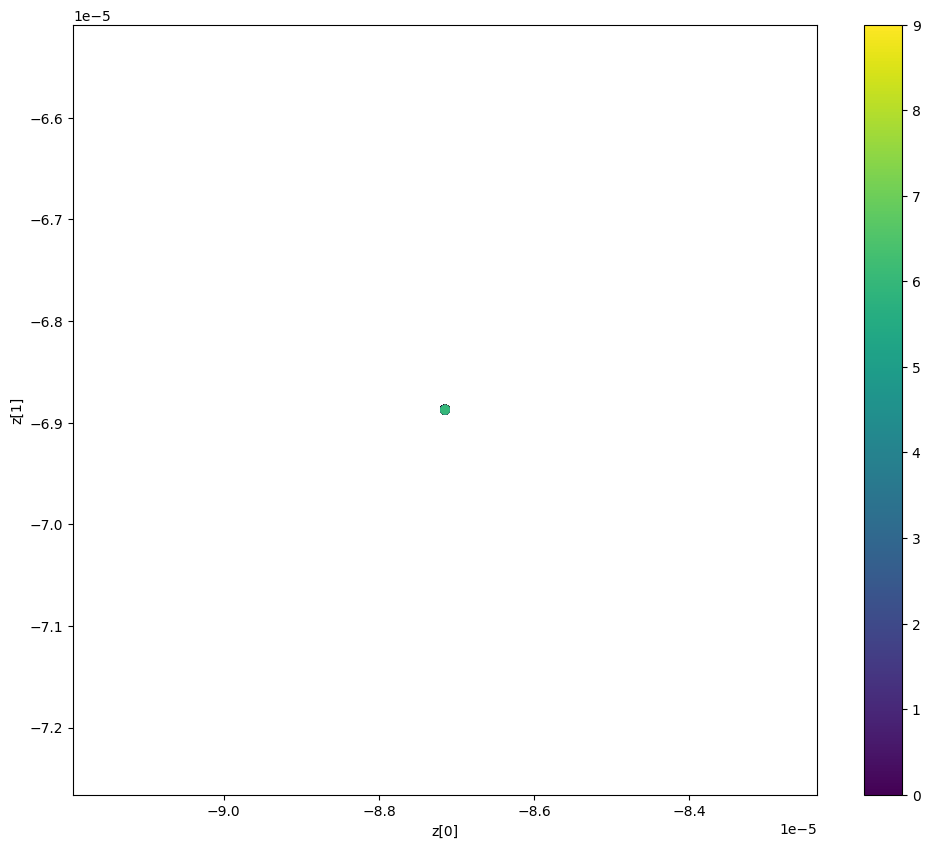

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

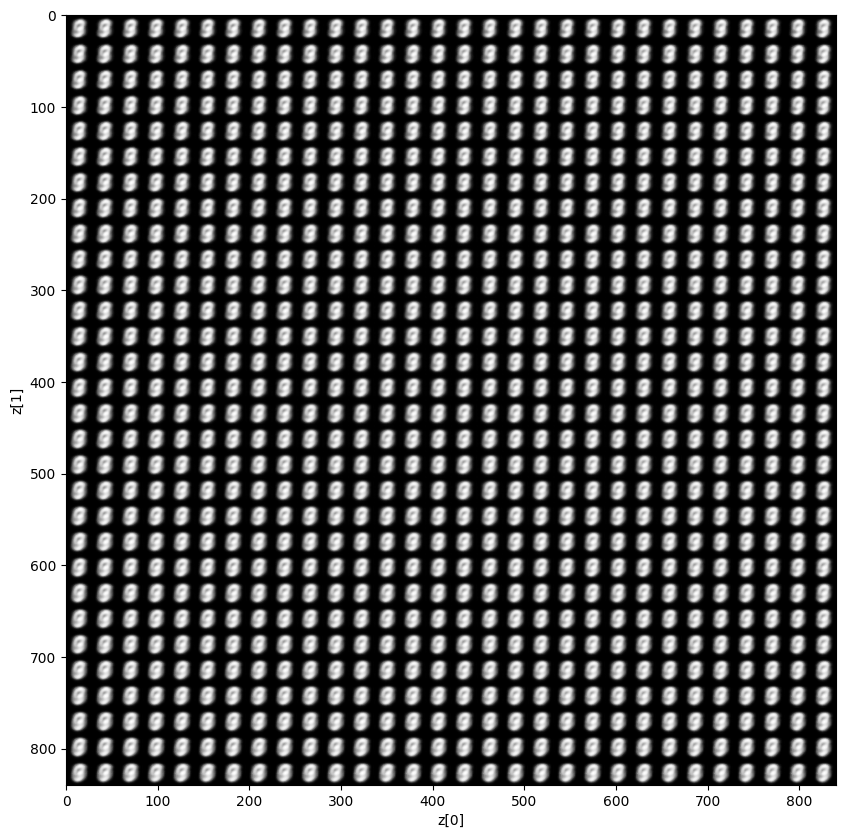

In [33]:
models = (encoder, decoder)
data = (x_test, y_test)

plot_results(models, data, batch_size=batch_size)


### Task: Play around with the representation!

TASK: give in two coordinates as data for the decoder, and observe the result!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


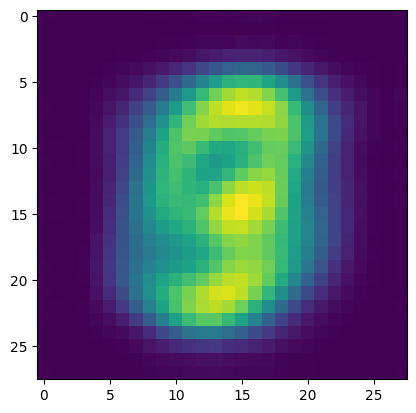

In [34]:
data = [1.0, -0.5]


z_sample = np.array([data])
x_decoded = decoder.predict(z_sample)

plt.imshow(x_decoded.reshape(image_size,image_size))
plt.show()


### We save the encoder model for transfer learning

In [35]:
encoder.save("encoder.h5")

# Transfer learning on notMNIST

## Loading the model

In [48]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

loaded_encoder = load_model("encoder.h5", custom_objects={'sampling': sampling})

# ---- Optional task AFTER the notebook is finished ---
# You canget back to here...
#
# This would keep the encoder static. Worth a try what it does :-)
#for layer in loaded_encoder.layers:
#        layer.trainable = False


## Loading and normalizing the data

No task here

In [49]:
! wget https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/t10k-images-idx3-ubyte.gz
! wget https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/t10k-labels-idx1-ubyte.gz
! wget https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/train-images-idx3-ubyte.gz
! wget https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/train-labels-idx1-ubyte.gz


--2024-09-21 19:30:48--  https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/t10k-images-idx3-ubyte.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davidflanagan/notMNIST-to-MNIST/master/t10k-images-idx3-ubyte.gz [following]
--2024-09-21 19:30:49--  https://raw.githubusercontent.com/davidflanagan/notMNIST-to-MNIST/master/t10k-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3172375 (3.0M) [application/octet-stream]
Saving to: ‘t10k-images-idx3-ubyte.gz.1’

t10k-images-idx3-ub 100%[===================>]   3.03M  --.-KB/s    in 0.02s   

2024-09-21 19:30:49 (16

In [50]:
import os
import gzip

def load_NOTmnist(path, kind='train'):
    """Load MNIST data from `path`.
    """
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [51]:
train_images, train_labels = load_NOTmnist('.')
valid_images, valid_labels = load_NOTmnist('.', 't10k')

In [52]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import concatenate, Dropout


classes = 10


train_labels = train_labels.astype('int32')
train_labels = to_categorical(train_labels, 10)

train_images = train_images.astype('float32') / 255.
train_images = train_images.reshape((-1, image_size, image_size, 1))

valid_labels = valid_labels.astype('int32')
valid_labels = to_categorical(valid_labels, 10)

valid_images = valid_images.astype('float32') / 255.
valid_images = valid_images.reshape((-1, image_size, image_size, 1))


print("Loaded data X shape:", train_images.shape)
print("Loaded data Y shape:", train_labels.shape)


Loaded data X shape: (60000, 28, 28, 1)
Loaded data Y shape: (60000, 10)


## Task: Defining the model

TASK: Observe the definition of the model, especially:
- the call for the loaded model
- the concatenation of the encoder output
- the final softmax layer
- the metrics we use

In [53]:
inputs = Input(shape=input_shape, name='encoder_input')

latent = loaded_encoder(inputs) #trainable=False?? You can get back to this LATER in the optional task above...

concat = concatenate(latent[0:2])

x = Dense(100, activation="relu")(concat)

predictions = Dense(10, activation='softmax')(x)

discriminator = Model(inputs, predictions, name='discriminator')

discriminator.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
discriminator.summary()

plot_model(discriminator, show_shapes=True)

plt.show()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 2), (None, 2), │         69,076 │ encoder_input[0][0]    │
│                           │ (None, 2)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 4)              │              0 │ encoder[0][0],         │
│ (Concatenate)             │                        │                │ encoder[0][1]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 100)            │            500 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 10)             │          1,010 │ dense_11[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,586 (275.73 KB)

 Trainable params: 70,586 (275.73 KB)

 Non-trainable params: 0 (0.00 B)

## Task: Training the model

TASK: Observe how the training progresses! Share your observations!

In [54]:
discriminator.fit(x=train_images, y=train_labels, batch_size=128, epochs=5, validation_data=(valid_images, valid_labels))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1159 - loss: 2.2582 - val_accuracy: 0.2709 - val_loss: 1.7410
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2978 - loss: 1.7051 - val_accuracy: 0.7952 - val_loss: 0.7656
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7585 - loss: 0.8348 - val_accuracy: 0.8984 - val_loss: 0.3511
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8420 - loss: 0.5310 - val_accuracy: 0.9180 - val_loss: 0.2803
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8616 - loss: 0.4512 - val_accuracy: 0.9214 - val_loss: 0.2540
